In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import spectra as spec

In [4]:
from __future__ import unicode_literals

figsize(8, 6)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [5]:
freqs = np.logspace(8, 13, 2000)
nu = freqs*1.e-9

In [6]:
# aperture is from 67' to 90' because of the size of our GBT maps. 

In [7]:
# 408 MHz
haslamfreq = [408.e6]
haslamflux = [23.60]
haslamerr = [4.7]
cgpsflux = [21.37]
cgpserr = [4.]

In [8]:
# 1420 MHz
stockertfreq = [1.42e9]
stockertflux = [19.41]
stockerterr = [4.]

In [9]:
# GBT
gbtA = 16.11
gbtB = 16.81
gbtC = 18.76
gbtAerr = 2.2
gbtBerr = 2.28
gbtCerr = 2.33
gbtfreqs = [4.575e9, 5.625e9, 6.125e9]
gbtflux = [gbtA, gbtB, gbtC]
gbterrs = [gbtAerr, gbtBerr, gbtCerr]

In [10]:
spectrum = spec.AperturePhotometry(inside=67., outside=90.)

In [11]:
# WMAP
wmapfreqs = spectrum.wmapfreqs
wmapflux, wmaperrs = spectrum.run_experiment(spectrum.wmapfiles)
wmaperrs = np.sqrt((0.03 * np.array(wmapflux))**2 + np.array(wmaperrs)**2)

In [12]:
# Planck
planckfreqs = spectrum.planckfreqs
planckflux, planckerrs = spectrum.run_experiment(spectrum.planckfiles)
planckerrs = np.sqrt( (0.03 * np.array(planckflux))**2 + np.array(planckerrs)**2)

In [13]:
# IRIS
irisfreqs = spectrum.irisfreqs
irisflux, iriserrs = spectrum.run_experiment(spectrum.irisfiles)
iriserrs = np.array(iriserrs) * 5.

In [14]:
# DIRBE
dirbefreqs = spectrum.dirbefreqs
dirbeflux, dirbeerrs = spectrum.run_experiment(spectrum.dirbefiles)
dirbeerrs = np.array(dirbeerrs) * 3.

In [15]:
bigfreqs = np.concatenate([haslamfreq, haslamfreq, stockertfreq, gbtfreqs, wmapfreqs, planckfreqs, irisfreqs, dirbefreqs])

In [16]:
bigflux = np.concatenate([haslamflux, cgpsflux, stockertflux, gbtflux, wmapflux, planckflux, irisflux, dirbeflux])

In [17]:
bigerrs = np.concatenate([haslamerr, cgpserr, stockerterr, gbterrs, wmaperrs, planckerrs, iriserrs, dirbeerrs])

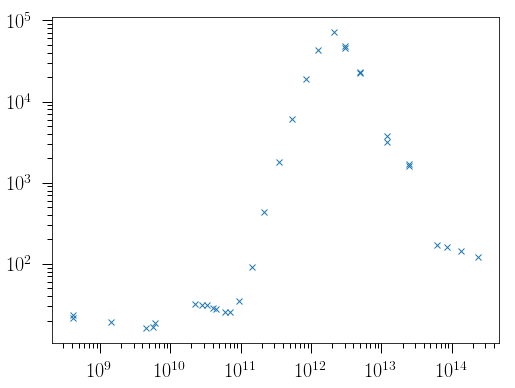

In [18]:
loglog(bigfreqs, bigflux, 'x')

In [19]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [20]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [21]:
beam = pi*(1.*pi/180.)**2
beam2 = pi*((1./60.)*pi/180.)**2

In [22]:
mask = bigfreqs < 3e12

In [23]:
pn = np.array([100., 1.e-3, 20.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfreqs[mask], bigflux[mask], p0=pn, sigma=bigerrs[mask], absolute_sigma=True)
pfit1 = x[0]

In [24]:
pn2 = np.array([100., 1.e9, 5.e-10, 1.e-4, 2., 20., 30e-6])
y = curve_fit(signal2, bigfreqs[mask], bigflux[mask], p0=pn2, sigma=bigerrs[mask], absolute_sigma=True)
pfit2 = y[0]

In [25]:
pfit1

array([  2.13490138e+02,   8.67902903e-04,   3.08378826e+10,
         6.97109553e-04,   1.51759589e+00,   2.28546435e+01,
         1.96191918e-05])

In [26]:
pfit2

array([  1.75255520e+02,   7.23975657e+08,   4.60737512e-10,
         7.09562324e-04,   1.20261140e+00,   2.71908259e+01,
        -1.55575094e-04])

In [27]:
np.sqrt(4.60737512e-10 / pi) * 180. / pi * 60. * 60. # arcseconds

2.4979111306502078

In [28]:
figsize(16, 10)

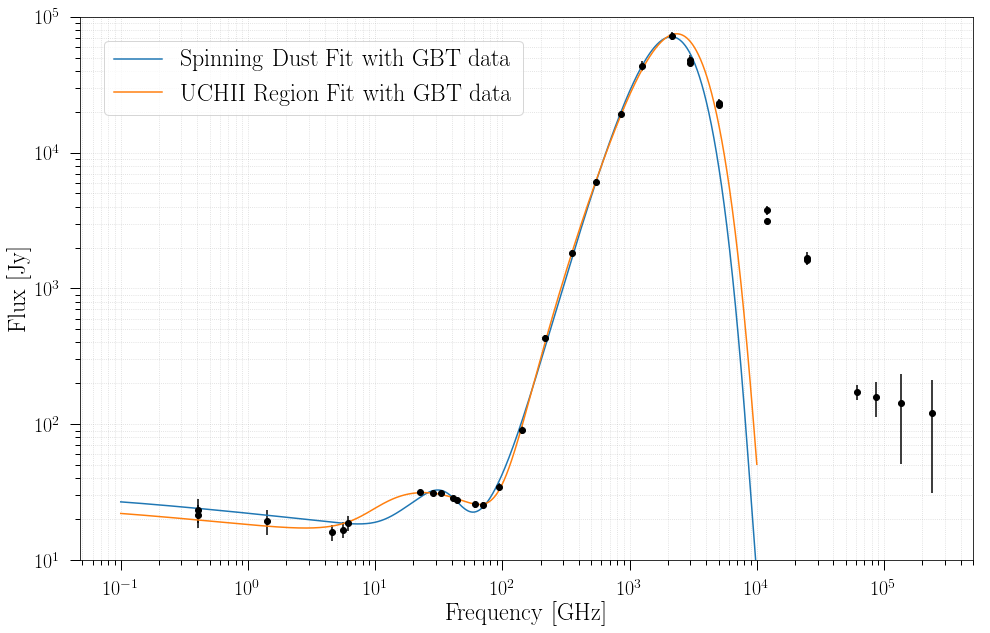

In [30]:
plot(nu, signal(freqs, *pfit1), label='$\mathrm{Spinning\ Dust\ Fit\ with\ GBT\ data}$')
plot(nu, signal2(freqs, *pfit2), label='$\mathrm{UCHII\ Region\ Fit\ with\ GBT\ data}$')
errorbar(bigfreqs*1.e-9, bigflux, yerr=bigerrs, fmt='ko')
#errorbar(bigfreqs*1.e-9, bigflux, yerr=bigerrs, fmt='ko',\
#         label='$\mathrm{Haslam,\ Reich,\ WMAP,}$\n$\mathrm{Planck,\ and\ DIRBE\ data}$')
#errorbar(nfreqs*1e-9, newdata, yerr=nerrs, fmt='rx', markersize=10)

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
legend(loc=2, ncol=1)
grid(ls='dotted', alpha=0.5)
grid(which='minor', ls='dotted', alpha=0.5)
ylim(10, 1e5)
savefig('../notebooks/newspectrum.pdf', format='pdf')

In [63]:
ame0a = fg.ame(freqs, pfit1[1], pfit1[2]) * beam
ff2a = fg.freefreep(freqs, EM=pfit2[1]) * pfit2[2]

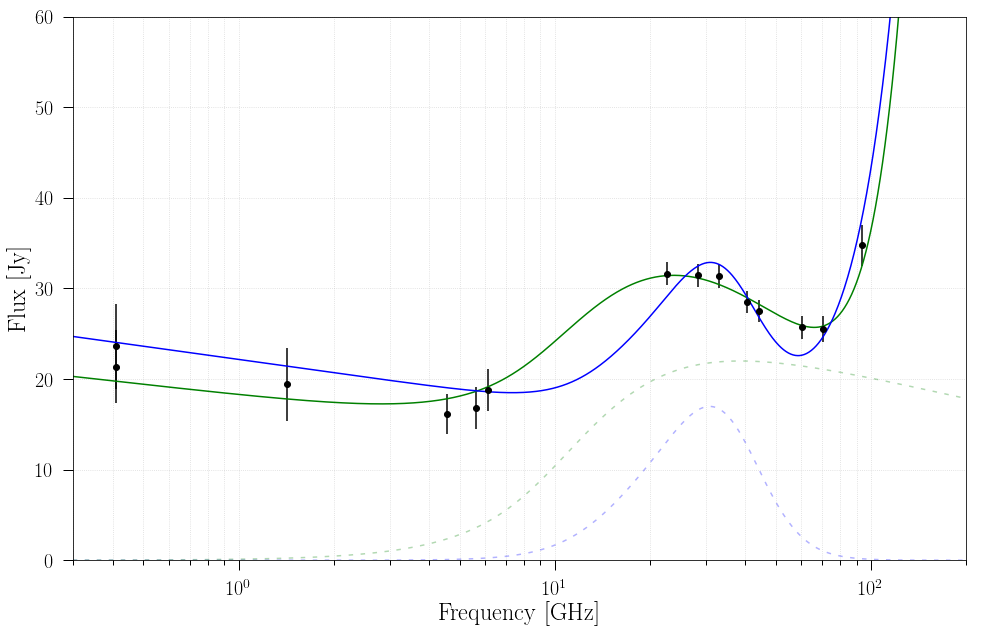

In [66]:
plot(nu, signal2(freqs, *pfit2), 'green')
plot(nu, signal(freqs, *pfit1), 'blue')
errorbar(bigfreqs*1.e-9, bigflux, yerr=bigerrs, fmt='ko')

alpha = 0.3
plot(nu, ame0a, 'blue', alpha=alpha, ls='dashed', dashes=(3,5))
plot(nu, ff2a, 'green', alpha=alpha, ls='dashed', dashes=(3,5))

xscale('log')
ylim(0, 60)
xlim(0.3, 200)
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
#legend(loc=2, ncol=2)
grid(ls='dotted', alpha=0.5)
grid(which='minor', ls='dotted', alpha=0.5)

#text(2, 5, '$\mathrm{UCHII\ free-free}$\n $\mathrm{component}$', fontsize=24, color='green', alpha=0.7);
#savefig('../notebooks/freefreefit.pdf', format='pdf')